<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Mahdi Salashour
### Student Number : 99101727
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [ ]:
# TODO

import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer




#read data
df = pd.read_csv('METABRIC_RNA_Mutation.csv')

#check missing values
print("Missing values distribution: ")
print(df.isnull().mean().sort_values(ascending = False))
print("")

#handle missing values
cat = df.select_dtypes('object').columns
num = df.select_dtypes('number').columns
df[num] = df[num].fillna(df.mean())
df[cat] = df[cat].fillna(df.mode().iloc[0])


#split target and features
y_df = df['overall_survival']
X_df = df.drop('death_from_cancer', axis =1)


# split clinical data and produce feature matrix by removing additional features
clinical_features_to_drop = X_df.columns[30:] 
clinical_df = df.drop(clinical_features_to_drop, axis=1)
X_clinical_df = clinical_df.drop(['patient_id', 'cancer_type','overall_survival','death_from_cancer'], axis=1)

# split gene data and produce feature matrix by removing additional features

genetic_features_to_drop = df.columns[519:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
genetic_features_to_drop = genetic_df.columns[2:34]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)
X_genetic_df = genetic_df.drop(['patient_id'], axis=1)

# split mut data 

mutation_features_to_drop = df.columns[2:519]
mutation_df = df.drop(mutation_features_to_drop, axis=1)

#one hot encode the categorical data in clinical part to use the for training further models
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_clinical_df)
X_clinical_df = pd.get_dummies(X_clinical_df)

#split train and test data for clinical and gene part
X_train_clinical, X_test_clinical, y_train_clinical, y_test_clinical = train_test_split(X_clinical_df, y_df, test_size=0.30, random_state=43)
X_train_genetic, X_test_genetic, y_train_genetic, y_test_genetic = train_test_split(X_genetic_df, y_df, test_size=0.30, random_state=43)





/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.



Missing values distribution: 
tumor_stage                  0.263130
3-gene_classifier_subtype    0.107143
primary_tumor_laterality     0.055672
neoplasm_histologic_grade    0.037815
cellularity                  0.028361
                               ...   
mmp15                        0.000000
mmp16                        0.000000
mmp17                        0.000000
mmp19                        0.000000
siah1_mut                    0.000000
Length: 693, dtype: float64



<ipython-input-13-59383303f41f>:32: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



as we can see tumor_stage and 3-gene classifier has a lot of missing values

## EDA

For each dataset, you must perform a sufficient EDA.

In [ ]:
clinical_df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [ ]:
clinical_df.info()
clinical_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1904 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1904 non-null   object 
 5   cellularity                     1904 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1904 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1904 non-null   float64
 12  her2_status_measured_by_snp6    19

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,2358.478332,12.978711,0.405971,1.228615,0.638185,0.486343,4.079993,4.010503,1.144492,76.334148,0.493800,0.490597,15.081097,0.539889
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,4730.500000,61.770000,0.000000,3.000000,2.415939,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,1.750535
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


In [ ]:
genetic_df.head()

,patient_id,age_at_diagnosis,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
0,0,75.65,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,-0.4294,...,2.8796,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847
1,2,43.19,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,0.5120,...,0.2446,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398
2,5,48.87,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,0.2362,...,0.4593,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078
3,6,47.68,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,1.0078,...,1.3361,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320
4,8,76.97,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,-0.2961,...,-0.3201,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476


In [ ]:
genetic_df.info()
genetic_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 487 entries, patient_id to ugt2b17
dtypes: float64(486), int64(1)
memory usage: 7.1 MB


,patient_id,age_at_diagnosis,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
count,1904.000000,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,...,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000
mean,3921.982143,61.087054,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,-4.726891e-07,...,0.000001,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000
std,2358.478332,12.978711,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,1.000263e+00,...,1.000263,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262
min,0.000000,21.930000,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,-3.060200e+00,...,-2.499500,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600
25%,896.500000,51.375000,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,-6.838250e-01,...,-0.702875,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200
50%,4730.500000,61.770000,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,-5.785000e-02,...,-0.174300,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400
75%,5536.250000,70.592500,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,5.362750e-01,...,0.506575,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375
max,7299.000000,96.290000,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,4.850100e+00,...,4.587100,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900


In [ ]:
mutation_df.head()

,patient_id,age_at_diagnosis,ugt2b7,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,-0.3354,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,-0.8920,0,H178P,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,0.3655,H1047R,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,-0.4828,E542K,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,1.3223,0,S241F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mutation_df.info()
mutation_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 176 entries, patient_id to siah1_mut
dtypes: float64(2), int64(1), object(173)
memory usage: 2.6+ MB


,patient_id,age_at_diagnosis,ugt2b7
count,1904.000000,1904.000000,1.904000e+03
mean,3921.982143,61.087054,3.731842e-18
std,2358.478332,12.978711,1.000262e+00
min,0.000000,21.930000,-1.051600e+00
25%,896.500000,51.375000,-7.260000e-01
50%,4730.500000,61.770000,-4.248000e-01
75%,5536.250000,70.592500,4.284000e-01
max,7299.000000,96.290000,3.284400e+00


In [ ]:
import plotly.express as px
px.scatter(df, x = "age_at_diagnosis", y = "cancer_type", color="overall_survival" )

as we can see when age grows chance of death grows too

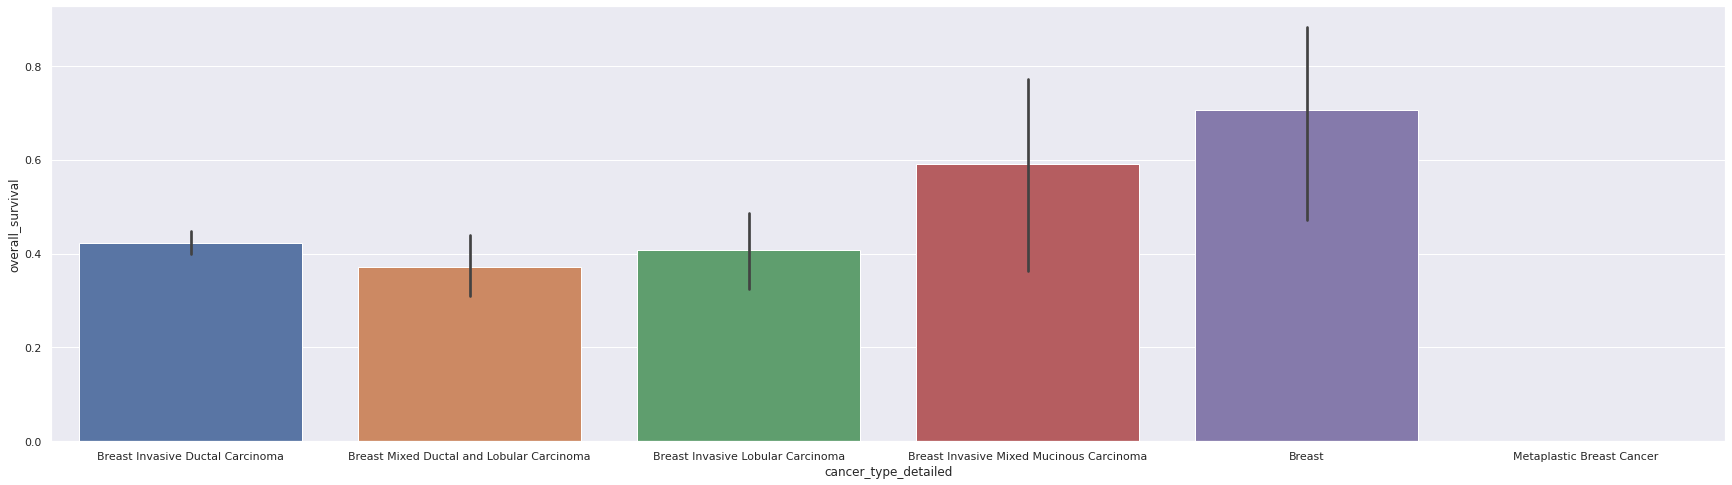

In [ ]:
sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x = df["cancer_type_detailed"], y = df["overall_survival"] )
plt.show()

here we can see diffrent types of breast cancer

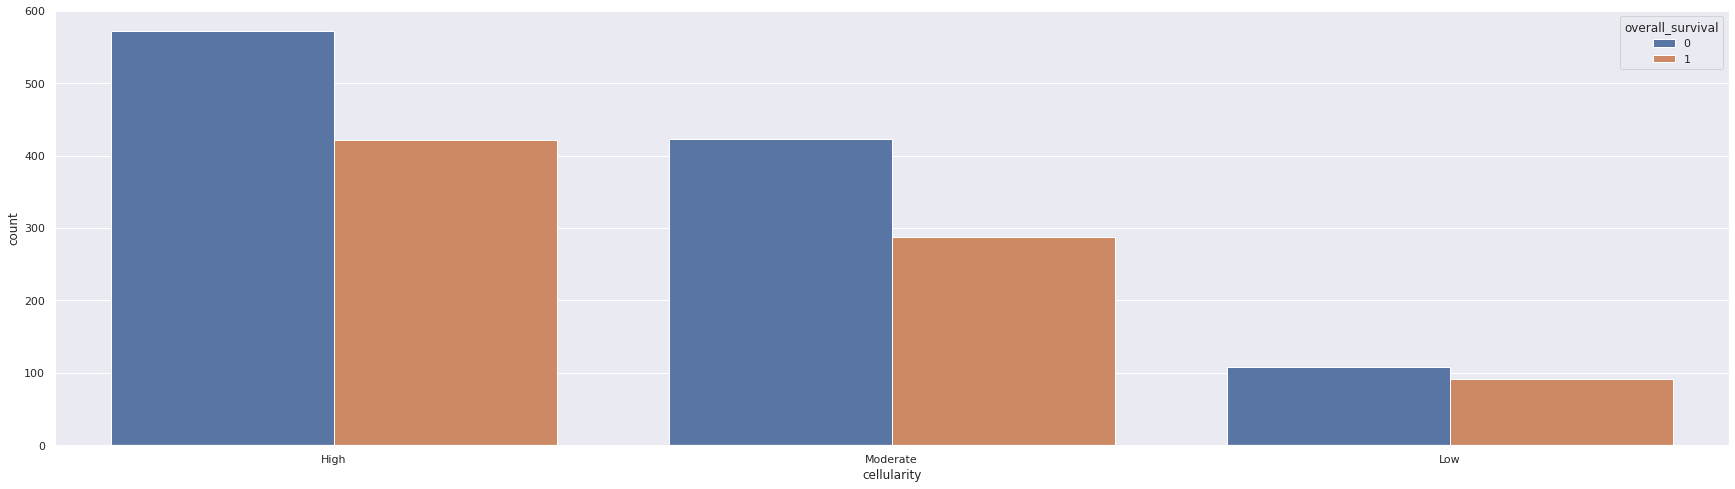

In [ ]:
sns.countplot(x = df["cellularity"], hue = df["overall_survival"])
plt.show()

here we can see diffrent levels of cellualarity and their cap-table at all.

as you can see in low cellularity level chance of survival is higher than  when the cellualrity is hogh or moderate

In [ ]:
px.histogram(df, x="lymph_nodes_examined_positive", color="overall_survival")

As the lympth nodes examined positive increases, the chance of survival decreases

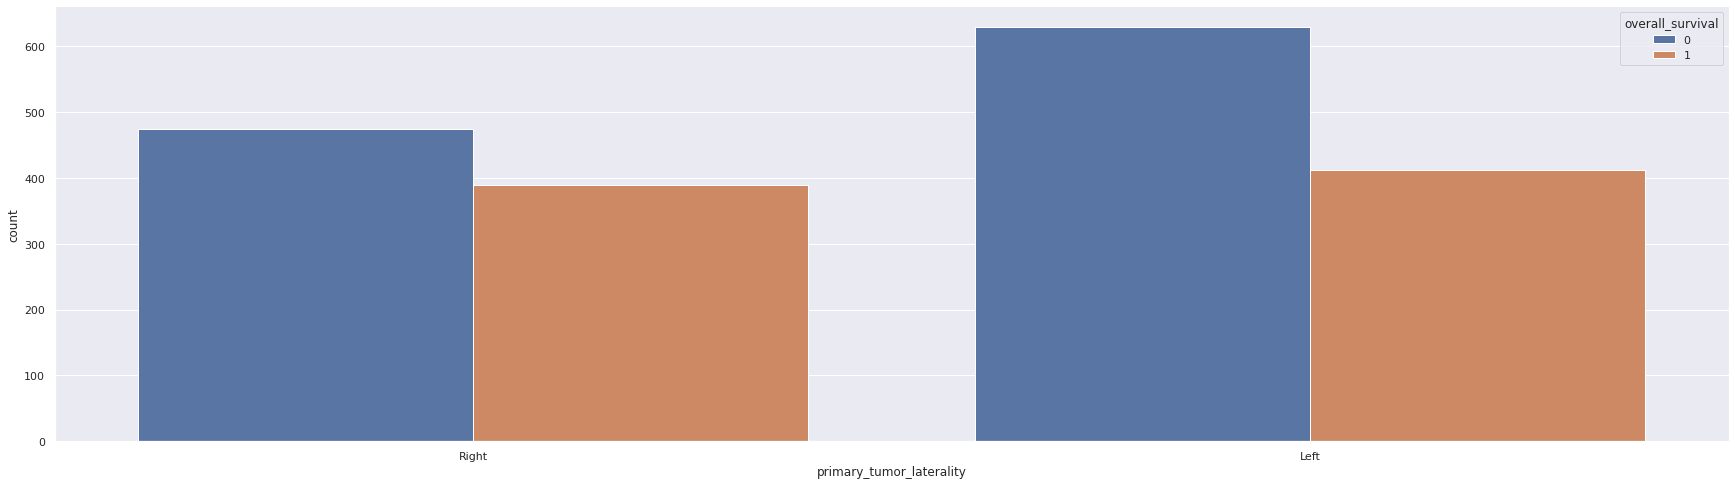

In [ ]:
sns.countplot(x = df["primary_tumor_laterality"], hue = df["overall_survival"])
plt.show()

as you can see in the plots we have more primary_tumor_laterality in left breast , but there isnt that much diffrence at all

In [ ]:
px.histogram(df, x = "overall_survival", pattern_shape="chemotherapy",color_discrete_sequence=['indianred'], text_auto=True)

using chemotherapy increases chance of survival about to 21% more than ussual

## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#standardize the data 
scaler = StandardScaler()
scaler.fit(X_train_genetic)
X_train_genetic = scaler.transform(X_train_genetic)
X_test_genetic = scaler.transform(X_test_genetic)
#check how many of the principal comps explain how much of the varicance of data
lst = []
for i in range(1,200,5):
    pca = PCA(n_components=i)
    pca.fit(X_train_genetic)
    principal_components = pca.transform(X_train_genetic)
    lst.append(np.sum(pca.explained_variance_ratio_))
px.line(lst)



 variance expalined ratio from 0 to 200 components(each step in chart indicates 5 comps)

In [ ]:
# using above line chart choose proper number of features and produce reduced genetic data
pca = PCA(n_components=50)
reduced_X_train_genetic = pca.fit_transform(X_train_genetic)
reduced_X_test_genetic = pca.transform(X_test_genetic)


# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#clinical random forest model predict
clinical_classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 0)
clinical_classifier.fit(X_train_clinical,y_train_clinical)
y_pred_clinical = clinical_classifier.predict(X_test_clinical)
print('Train score for clinical data is: ', clinical_classifier.score(X_train_clinical, y_train_clinical))
print('Test score for clinical data is:    ', clinical_classifier.score(X_test_clinical, y_test_clinical))
print('Classification Reportfor clinical data is: ')
print(classification_report(y_test_clinical, y_pred_clinical))

Train score for clinical data is:  0.996996996996997
Test score for clinical data is:     0.7534965034965035
Classification Reportfor clinical data is: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       343
           1       0.72      0.64      0.67       229

    accuracy                           0.75       572
   macro avg       0.75      0.73      0.74       572
weighted avg       0.75      0.75      0.75       572



In [ ]:
#gene random forest model predict

gene_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
gene_classifier.fit(X_train_genetic,y_train_genetic)
gene_y_pred = gene_classifier.predict(X_test_genetic)
print('Train score for genetic data is: ', gene_classifier.score(X_train_genetic, y_train_genetic))
print('Test score for genetic data is:    ', gene_classifier.score(X_test_genetic, y_test_genetic))
print('Classification Reportfor genetic data is: ')
print(classification_report(y_test_genetic, gene_y_pred))

Train score for genetic data is:  1.0
Test score for genetic data is:     0.6888111888111889
Classification Reportfor genetic data is: 
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       343
           1       0.69      0.41      0.51       229

    accuracy                           0.69       572
   macro avg       0.69      0.64      0.64       572
weighted avg       0.69      0.69      0.67       572



In [ ]:
#reduced gene random forest oredict
reduced_gene_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
reduced_gene_classifier.fit(reduced_X_train_genetic,y_train_genetic)
red_gen_y_pred = reduced_gene_classifier.predict(reduced_X_test_genetic)
print('Train score for genetic data is: ', reduced_gene_classifier.score(reduced_X_train_genetic, y_train_genetic))
print('Test score for genetic data is:    ', reduced_gene_classifier.score(reduced_X_test_genetic, y_test_genetic))
print('Classification Reportfor genetic data is: ')
print(classification_report(y_test_genetic, red_gen_y_pred))

Train score for genetic data is:  1.0
Test score for genetic data is:     0.666083916083916
Classification Reportfor genetic data is: 
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       343
           1       0.63      0.40      0.49       229

    accuracy                           0.67       572
   macro avg       0.65      0.62      0.62       572
weighted avg       0.66      0.67      0.65       572



# Neural Network (30 Points)

In [ ]:
# a def to convert each prediction to 1 or 0 based on predicted probability.
def neural_pred_classification(pred):
  for i in range(len(pred)):
    if pred[i] < 0.5:
        pred[i] = 0
    else:
        pred[i] = 1
  return pred

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

18/18 [==============================] - 0s 2ms/step
Test score for clinical data is:     0.6975524475524476
Classification Reportfor clinical data is: 
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       343
           1       0.62      0.64      0.63       229

    accuracy                           0.70       572
   macro avg       0.69      0.69      0.69       572
weighted avg       0.70      0.70      0.70       572



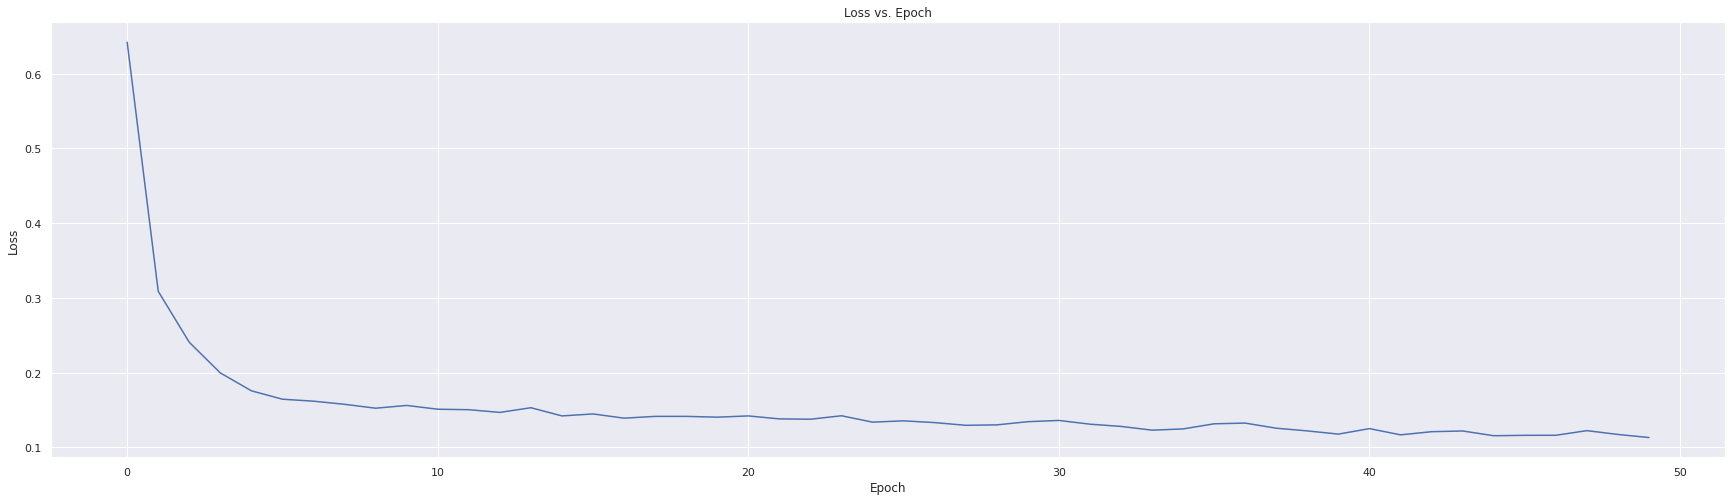

In [ ]:
# TODO
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout



#create a multi layer neural network (four layers fully connected)
clinical_neural = Sequential()
clinical_neural.add(Dense(128, input_shape=(75,), activation='relu'))
clinical_neural.add(BatchNormalization())
clinical_neural.add(Dense(64, activation='sigmoid'))
clinical_neural.add(BatchNormalization())
clinical_neural.add(Dense(16, activation='sigmoid'))
clinical_neural.add(BatchNormalization())
clinical_neural.add(Dense(1, activation='linear'))

# Configure the model and start training for 50 epochs and 64 batch size
clinical_neural.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
clinical_model_history = clinical_neural.fit(X_train_clinical, y_train_clinical, epochs=50, batch_size=64, verbose=0, validation_split=0.3)
#predict the test data
clinical_y_pred = clinical_neural.predict(X_test_clinical)
clinical_y_pred = neural_pred_classification(clinical_y_pred)
#show accuracy
print('Test score for clinical data is:    ', accuracy_score(clinical_y_pred, y_test_clinical))
print('Classification Reportfor clinical data is: ')
print(classification_report(y_test_clinical, clinical_y_pred))

# show train loss chart
plt.plot(clinical_model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)


18/18 [==============================] - 0s 2ms/step
Test score for genetic data is:     0.6486013986013986
Classification Reportfor genetic data is: 
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       343
           1       0.56      0.54      0.55       229

    accuracy                           0.65       572
   macro avg       0.63      0.63      0.63       572
weighted avg       0.65      0.65      0.65       572



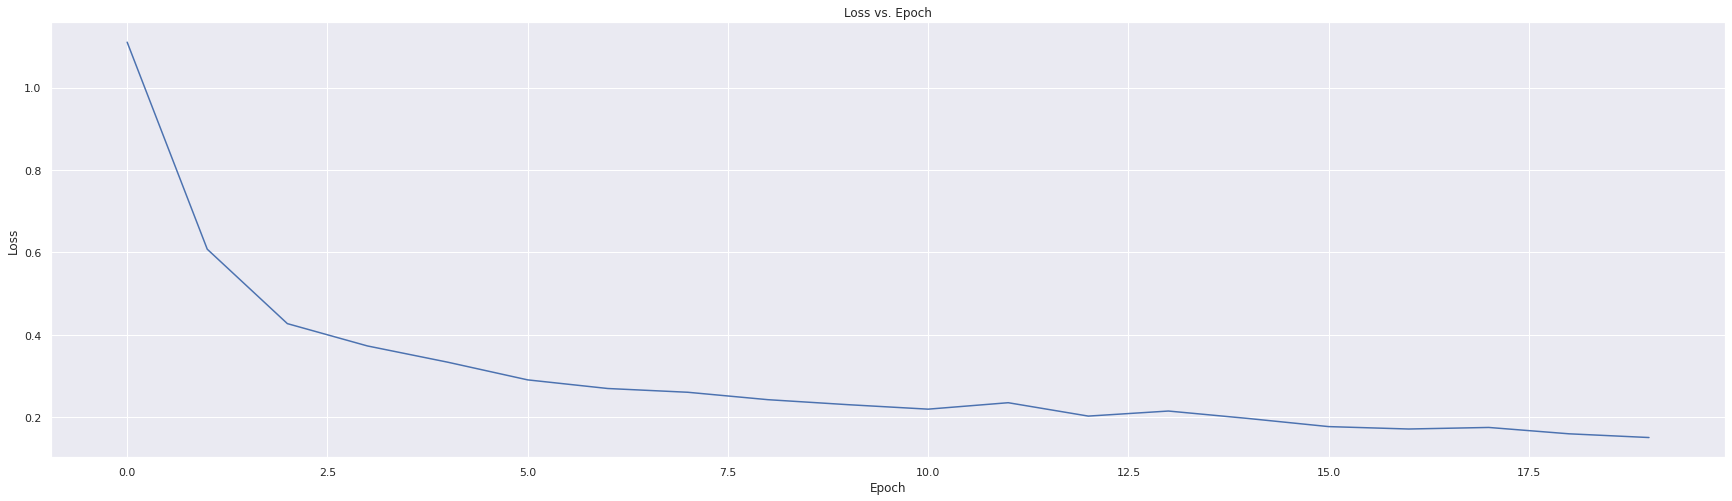

In [ ]:
genetic_neural = Sequential()
genetic_neural.add(Dense(256, input_shape=(486,), activation='relu'))
genetic_neural.add(BatchNormalization())
genetic_neural.add(Dropout(0.40))
genetic_neural.add(Dense(128, activation='sigmoid'))
genetic_neural.add(BatchNormalization())
genetic_neural.add(Dense(64, activation='sigmoid'))
genetic_neural.add(BatchNormalization())
genetic_neural.add(Dropout(0.40))
genetic_neural.add(Dense(32, activation='sigmoid'))
genetic_neural.add(BatchNormalization())
genetic_neural.add(Dropout(0.40))
genetic_neural.add(Dense(16, activation='sigmoid'))
genetic_neural.add(BatchNormalization())
genetic_neural.add(Dense(1, activation='linear'))

# Configure the model and start training
genetic_neural.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
gene_model_history = genetic_neural.fit(X_train_genetic, y_train_genetic, epochs=20, batch_size=64, verbose=0, validation_split=0.3)
#predict the test data
genetic_y_pred = genetic_neural.predict(X_test_genetic)
genetic_y_pred = neural_pred_classification(genetic_y_pred)
#show accuracy
print('Test score for genetic data is:    ', accuracy_score(genetic_y_pred, y_test_genetic))
print('Classification Reportfor genetic data is: ')
print(classification_report(y_test_genetic, genetic_y_pred))

# show train loss chart
plt.plot(gene_model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

18/18 [==============================] - 0s 2ms/step
Test score for genetic data is:     0.6241258741258742
Classification Reportfor genetic data is: 
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       343
           1       0.54      0.47      0.50       229

    accuracy                           0.62       572
   macro avg       0.60      0.60      0.60       572
weighted avg       0.62      0.62      0.62       572



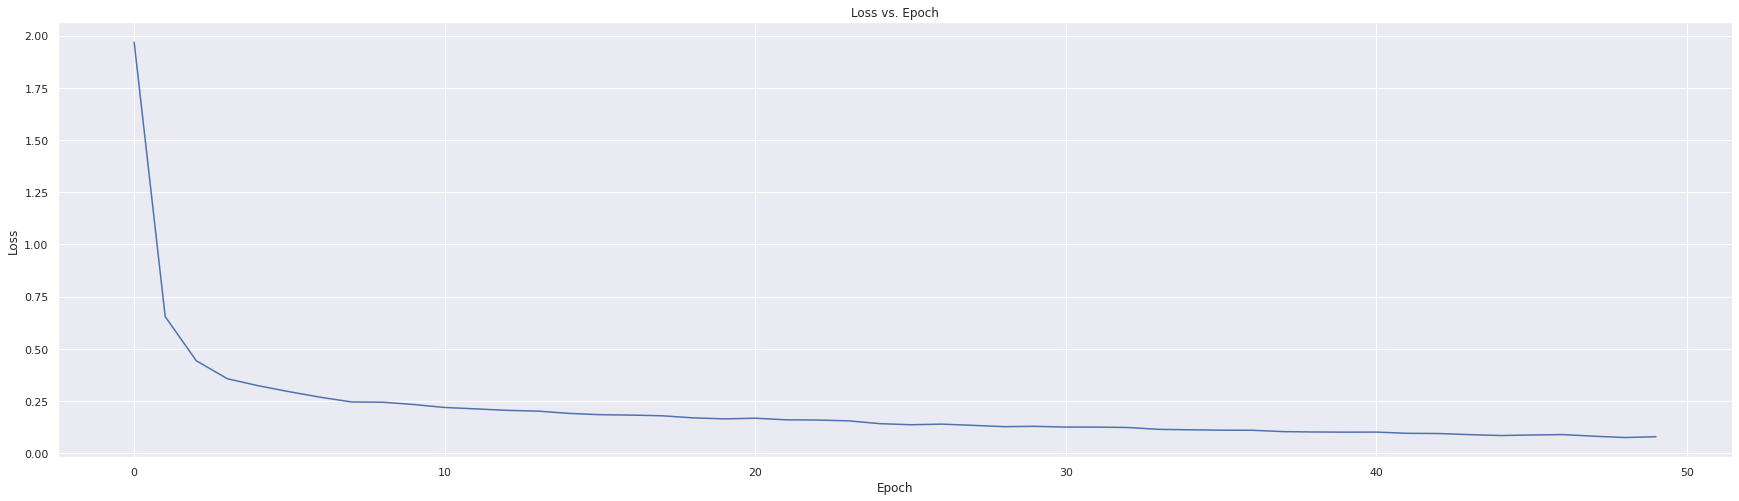

In [ ]:
reduced_genetic_neural = Sequential()
reduced_genetic_neural.add(Dense(50, input_shape=(50,), activation='relu'))
reduced_genetic_neural.add(BatchNormalization())
genetic_neural.add(Dropout(0.40))
reduced_genetic_neural.add(Dense(25, activation='sigmoid'))
reduced_genetic_neural.add(BatchNormalization())
genetic_neural.add(Dropout(0.40))
reduced_genetic_neural.add(Dense(12, activation='sigmoid'))
reduced_genetic_neural.add(BatchNormalization())
reduced_genetic_neural.add(Dense(1, activation='linear'))

# Configure the model and start training
reduced_genetic_neural.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
reduced_gene_model_history = reduced_genetic_neural.fit(reduced_X_train_genetic, y_train_genetic, epochs=50, batch_size=64, verbose=0, validation_split=0.3)
#predict the test data
reduced_genetic_y_pred = reduced_genetic_neural.predict(reduced_X_test_genetic)
reduced_genetic_y_pred = neural_pred_classification(reduced_genetic_y_pred)
#show accuracy
print('Test score for genetic data is:    ', accuracy_score(reduced_genetic_y_pred, y_test_genetic))
print('Classification Reportfor genetic data is: ')
print(classification_report(y_test_genetic, reduced_genetic_y_pred))

# show train loss chart
plt.plot(reduced_gene_model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

#### \# TODO

As you see in results,

Accuray of prediction on our datasets in Randomforest is higher than neural network

The main reason is "size of our dataset" , our dataset is too small for making predictions by neural network and we need a dataset with many more samples 
Also our randomforest works well here
Because it can predict responses with fewer samples

Accuracy in clinical dataset is higher than gene and reduced gene datasets
In both models . The main reason is we have fewer features in clinical dataset and its prevent overfitting but when you have many features , you may overfit in predicting the respones

Also there is not that much difference between predicting for gene and reduced gene datasets

It may have several reasons such as:

1 - variance distribution among dataset is uniform and as we saw in the pca variance explanation ratio plot when we use more features we can increase variance explanation ratio by considerable amount.

2- pca is not that much good dimension reduction model for this dataset because pca performs dimension reduction in linear based process